In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import common
import DataProcessing as dp
from scipy import stats
import seaborn as sns
from prettytable import PrettyTable
import TrainAndTest as tt

In [18]:
flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/1209/AMSineFA0_1.h5')
flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))

def PCCCalculation(sig1,sig2):
    if(sig1.ndim != sig2.ndim):
        print("signal 1 and signal 2 have different dimensions")
    elif(sig1.ndim == 1):
        real_corr, _ = stats.pearsonr(np.real(sig1), np.real(sig2))
        imag_corr, _ = stats.pearsonr(np.imag(sig1), np.imag(sig2))
    else:
        real_corr = np.zeros((sig1.shape[1]))
        imag_corr = np.zeros((sig1.shape[1]))
        for i in range(0, sig1.shape[1]):
            real_corr[i],_ = stats.pearsonr(np.real(sig1[i]), np.real(sig2[i]))
            imag_corr[i], _ = stats.pearsonr(np.imag(sig1[i]), np.imag(sig2[i]))
    return real_corr, imag_corr

sig = flip0

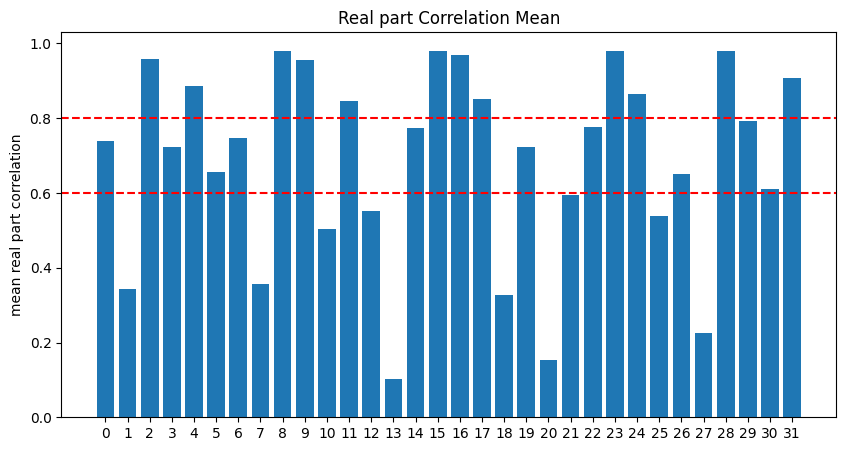

[0, 0, 512, 0, 0, 0, 0, 0, 0, 512, 0, 512, 0, 0, 0, 0, 0, 512, 0, 0, 0, 0, 7, 0, 512, 0, 0, 0, 0, 197, 0, 512]
[0, 0, 512, 0, 0, 0, 0, 0, 0, 512, 0, 512, 0, 0, 0, 0, 0, 512, 0, 0, 0, 0, 4, 0, 512, 0, 0, 0, 0, 191, 0, 512]


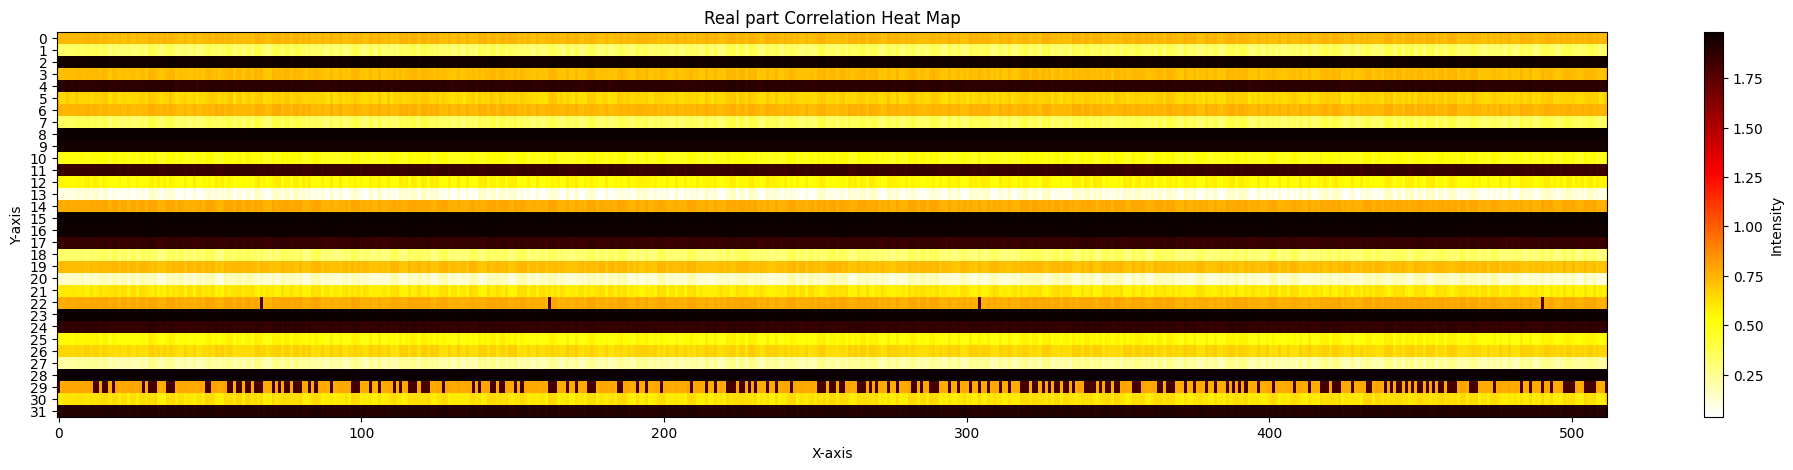

In [30]:

real_corr = []
imag_corr = []
for i in range(0,16):
    for k in range(16,18):
        real_corr_temp,imag_corr_temp = PCCCalculation(sig[:,i],sig[:,k])
        real_corr.append(real_corr_temp)
        imag_corr.append(imag_corr_temp)
mean_real_corr = np.mean(np.abs(real_corr),axis = 1)
mean_imag_corr = np.mean(np.abs(imag_corr),axis = 1)
plt.figure(figsize=(10,5))
plt.bar(range(32),mean_real_corr)
plt.ylabel('mean real part correlation')
plt.axhline(y=0.8, color='red', linestyle='--', label='y = 0.8')
plt.axhline(y=0.6, color='red', linestyle='--', label='y = 0.8')
plt.xticks(range(0, 32, 1))
plt.title('Real part Correlation Mean')
plt.show()

count_strong_real_corr = []
count_strong_imag_corr = []
for i in range(0,32):
    strong_real_corr = (real_corr[i] > 0.8)
    strong_imag_corr = (imag_corr[i] > 0.8)
    count_strong_real_corr.append(strong_real_corr.sum())
    count_strong_imag_corr.append(strong_imag_corr.sum())
    
print(count_strong_real_corr)
print(count_strong_imag_corr)
imag_corr = np.array(np.abs(imag_corr))
imag_corr[imag_corr >= 0.8] += 1
#heat plot
plt.figure(figsize=(25,5))
plt.imshow(imag_corr,aspect='auto',cmap='hot_r',interpolation='none')
plt.colorbar(label='Intensity')  # Add a color bar
plt.title("Real part Correlation Heat Map")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.yticks(range(0, 32, 1))
plt.show()

In [12]:
def frequencyBandDivision(sig, fd, bands):
    fft = np.abs(np.fft.fft(sig))
    sampling_frequency = common.getRate(fd)
    freqs = np.fft.fftfreq(len(sig),1/sampling_frequency)
    band_mask1 = (freqs >= bands[0,0]) & (freqs < bands[0,1])
    fft1 = fft * band_mask1
    band_mask2 = (freqs >= bands[1,0]) & (freqs < bands[1,1])
    fft2 = fft * band_mask2
    band_mask3 = (freqs >= bands[2,0]) & (freqs < bands[2,1])
    fft3 = fft * band_mask3
    return fft1,fft2,fft3

def TFCalculation(sig,fd,bands,channel=18):
    fft1 = []
    fft2 = []
    fft3 = []
    for i in range(0,18):
        fft1_temp,fft2_temp,fft3_temp = frequencyBandDivision(sig,fd,bands)
        fft1.append(fft1_temp)
        fft2.append(fft2_temp)
        fft3.append(fft3_temp)
    MRISignal1 = fft1[0:16]
    MRISignal2 = fft2[0:16]
    MRISignal3 = fft3[0:16]
    if channel == 18:
        EMISignal1 = fft1[16:18]
        EMISignal2 = fft2[16:18]
        EMISignal3 = fft3[16:18]
    else:
        EMISignal1 = fft1[channel]
        EMISignal2 = fft2[channel]
        EMISignal3 = fft3[channel]
    tf1 = np.zeros((16,2),dtype= np.complex64)
    tf1 = np.dot(MRISignal1,np.linalg.pinv(EMISignal1.reshape(1,len(EMISignal1))))
    tf2 = np.zeros((16,2),dtype= np.complex64)
    tf2 = np.dot(MRISignal2,np.linalg.pinv(EMISignal2.reshape(1,len(EMISignal1))))
    tf3 = np.zeros((16,2),dtype= np.complex64)
    tf3 = np.dot(MRISignal3,np.linalg.pinv(EMISignal3.reshape(1,len(EMISignal1))))
    return tf1,tf2,tf3


def denoising(sig,fd,bands,channel):
    tf1,tf2,tf3 = TFCalculation(sig[0],fd,bands,channel)

    fft1 = []
    fft2 = []
    fft3 = []
    for i in range(0,18):
        fft1_temp,fft2_temp,fft3_temp = frequencyBandDivision(sig[128],fd,bands)
        fft1.append(fft1_temp)
        fft2.append(fft2_temp)
        fft3.append(fft3_temp)
    MRISignal1 = fft1[0:16]
    MRISignal2 = fft2[0:16]
    MRISignal3 = fft3[0:16]
    if channel == 18:
        EMISignal1 = fft1[16:18]
        EMISignal2 = fft2[16:18]
        EMISignal3 = fft3[16:18]
    else:
        EMISignal1 = fft1[channel]
        EMISignal2 = fft2[channel]
        EMISignal3 = fft3[channel]
    denoised = sig[128,0:16]

    pred1 = np.dot(EMISignal1,tf1)
    pred2 = np.dot(EMISignal2,tf2)
    pred3 = np.dot(EMISignal3,tf3)
    pred = np.concatenate((pred1,pred2,pred3),axis=1)
    denoised = denoised - np.fft.ifft(pred)
    return denoised



In [11]:
def TFCalculation2(sig,channel=18):
    MRISignal = sig[0:16]
    if channel == 18:
        EMISignal = sig[16:18]
        tf = np.zeros((16,2),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal))
    else:
        EMISignal = sig[channel]
        tf = np.zeros((16,1),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal.reshape(1,len(EMISignal))))
    return tf

def denoising2(sig,channel2=18):
    tf = TFCalculation2(sig[0], channel2)
    denoised = np.zeros((511,16,512),dtype=np.complex64)
    for i in range(511):
        if channel2 == 18:
            EMISignal = sig[i+1,16:18]
            pred = np.dot(tf,EMISignal)
            denoised[i] = sig[i+1,0:16] - pred
        else:
            EMISignal = sig[i+1,channel2]
            pred = np.dot(tf,EMISignal.reshape(1,512))
            denoised[i] = sig[i+1,0:16] - pred
    return denoised

def denoising3(sig,channel2=18):
    tf = TFCalculation2(sig[0], channel2)
    denoised = sig[128,0:16]
    if channel2 == 18:
        EMISignal = sig[128,16:18]
        pred = np.dot(tf,EMISignal)
        denoised = denoised - pred
    else:
        EMISignal = sig[128,channel2]
        pred = np.dot(tf,EMISignal.reshape(1,512))
        denoised = denoised - pred
    
    return denoised

In [10]:
def mean(sig):
    return np.mean(sig)

def peak(sig):
     return np.max(sig)

def std(sig):
     return np.std(sig, dtype=np.float64)

# before suppression/ after suppression of channel 16/ suppression rate (SR)/ after channel 17/ suppression rate / after channel 16+17/ suppression rate
# mean
# peak
# standard deviation
# PCC
def experiment1DTable(before,sup16,sup17,supComb):
    meanBefore = mean(before)
    peakBefore = peak(before)
    stdBefore = std(before)
    meanSup16 = mean(sup16)
    peakSup16 = peak(sup16)
    stdSup16 = std(sup16)
    SRMeanSup16 = 1 - (np.abs(meanSup16)/np.abs(meanBefore))
    SRPeakSup16 = 1 - (np.abs(peakSup16)/np.abs(peakBefore))
    SRStdSup16 = 1 - (np.abs(stdSup16)/np.abs(stdBefore))
    meanSup17 = mean(sup17)
    peakSup17 = peak(sup17)
    stdSup17 = std(sup17)
    SRMeanSup17 = 1 - (np.abs(meanSup17)/np.abs(meanBefore))
    SRPeakSup17 = 1 - (np.abs(peakSup17)/np.abs(peakBefore))
    SRStdSup17 = 1 - (np.abs(stdSup17)/np.abs(stdBefore))
    meanSupComb = mean(supComb)
    peakSupComb = peak(supComb)
    stdSupComb = std(supComb)
    SRMeanSupComb = 1 - (np.abs(meanSupComb)/np.abs(meanBefore))
    SRPeakSupComb = 1 - (np.abs(peakSupComb)/np.abs(peakBefore))
    SRStdSupComb = 1 - (np.abs(stdSupComb)/np.abs(stdBefore))
    table = PrettyTable(["","Before suppression", "After suppression with Channel 16",
                          "Suppression Rate1", "After suppression with Channel 17",
                          "Suppression Rate2","After suppression with Channel 16 and 17",
                          "Suppression Rate3"])
    table.add_row(["mean",meanBefore,meanSup16,SRMeanSup16,meanSup17,SRMeanSup17,meanSupComb,SRMeanSupComb]) 
    table.add_row(["peak",peakBefore,peakSup16,SRPeakSup16,peakSup17,SRPeakSup17,peakSupComb,SRPeakSupComb]) 
    table.add_row(["standard deviation",stdBefore,stdSup16,SRStdSup16,stdSup17,SRStdSup17,stdSupComb,SRStdSupComb]) 
    print(table)

In [ ]:

sup16 = denoising2(sig,channel2=16)

sup17 = denoising2(sig,channel2=17)
supcomb = denoising2(sig,channel2=18)
before = np.mean(sig[1:512,0:16],axis=0)
sup16 = np.mean(sup16, axis = 0)
sup17 = np.mean(sup17, axis = 0)
supcomb = np.mean(supcomb, axis = 0)

experiment1DTable(sig[128,0:16],sup16[127],sup17[127],supcomb[127])
before = np.mean(sig[1:512,0:16],axis=0)
sup16 = np.mean(sup16, axis = 0)
sup17 = np.mean(sup17, axis = 0)
supcomb = np.mean(supcomb, axis = 0)


+--------------------+----------------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|                    |     Before suppression     | After suppression with Channel 16 | Suppression Rate1  | After suppression with Channel 17 | Suppression Rate2  | After suppression with Channel 16 and 17 | Suppression Rate3  |
+--------------------+----------------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|        mean        | (0.0039129257+0.63346934j) |     (-0.05532783+0.022340259j)    |     0.9058096      |    (-0.04600215+0.0021661557j)    |     0.9273015      |       (-0.044422373+0.0069092102j)       |     0.9290327      |
|        peak        |   (576.5794-0.40318486j)   |       (48.890533-17.413443j)

In [ ]:
#fd = 'E:/JiaxingData/EMINoise/1209/AMSquareFA0_1.h5'
#bands = np.array([[0,5000],[5000,15000],[15000,32000]])
sup16 = denoising2(sig,channel2=16)
#sup16 = denoising3(sig,channel2=16)
sup17 = denoising2(sig,channel2=17)
supcomb = denoising2(sig,channel2=18)
before = np.mean(sig[1:512,0:16],axis=0)
sup16 = np.mean(sup16, axis = 0)
sup17 = np.mean(sup17, axis = 0)
supcomb = np.mean(supcomb, axis = 0)

experiment1DTable(sig[128,0:16],sup16[127],sup17[127],supcomb[127])
before = np.mean(sig[1:512,0:16],axis=0)
sup16 = np.mean(sup16, axis = 0)
sup17 = np.mean(sup17, axis = 0)
supcomb = np.mean(supcomb, axis = 0)

In [29]:
def experiment1D(sig):


    # step2
    sup16 = denoising2(sig,channel2=16)
    sup17 = denoising2(sig,channel2=17)
    supcomb = denoising2(sig,channel2=18)
    before = np.mean(sig[1:512,0:16],axis=0)
    sup16 = np.mean(sup16, axis = 0)
    sup17 = np.mean(sup17, axis = 0)
    supcomb = np.mean(supcomb, axis = 0)
    # step3
    experiment1DTable(before,sup16,sup17,supcomb)

In [55]:
#self-denoising
date = '20250122'
for mode in ['AM']:
    for type in ['Square']:
        for trial in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25']:
            flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'SFA0_'+trial+'.h5')
            flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))
            experiment1D(flip0)


C:\Users\11616\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:164: ComplexWarning: Casting complex values to real discards the imaginary part
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


+--------------------+--------------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|                    |    Before suppression    | After suppression with Channel 16 | Suppression Rate1  | After suppression with Channel 17 | Suppression Rate2  | After suppression with Channel 16 and 17 | Suppression Rate3  |
+--------------------+--------------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|        mean        | (0.0563044+0.010079093j) |    (0.0024088523-0.004952467j)    |     0.9037189      |    (0.004714613-0.0002592659j)    |     0.9174513      |       (0.0039076824-0.001076319j)        |     0.92913914     |
|        peak        | (29.149487-0.16138811j)  |       (3.3015606+0.6399627j)      |   

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:/JiaxingData/EMINoise/20250122/AMSquareSFA0_11.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

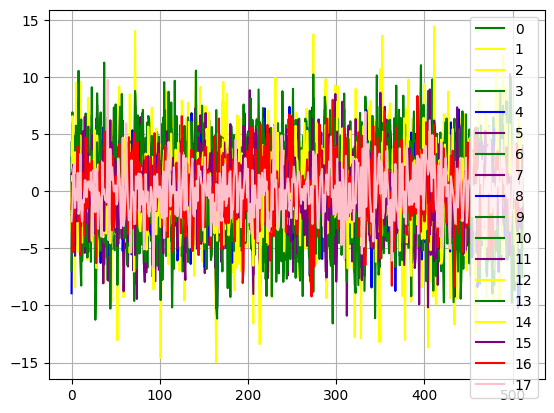

In [53]:
flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/1209/0115/AMSquareBFA0.h5')
flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))
sampling_frequency = common.getRate('C:/JiaxingData/EMINoise/1209/0115/AMSquareBFA0.h5')
freqs = np.fft.fftfreq(len(flip0),1/sampling_frequency)

plt.plot(np.real(flip0[0,0]),'g')
plt.plot(np.real(flip0[0,1]),'yellow')
plt.plot(np.real(flip0[0,2]),'yellow')
plt.plot(np.real(flip0[0,3]),'g')
plt.plot(np.real(flip0[0,4]),'blue')
plt.plot(np.real(flip0[0,5]),'purple')
plt.plot(np.real(flip0[0,6]),'g')
plt.plot(np.real(flip0[0,7]),'purple')
plt.plot(np.real(flip0[0,8]),'blue')
plt.plot(np.real(flip0[0,9]),'g')
plt.plot(np.real(flip0[0,10]),'g')
plt.plot(np.real(flip0[0,11]),'purple')
plt.plot(np.real(flip0[0,12]),'yellow')
plt.plot(np.real(flip0[0,13]),'g')
plt.plot(np.real(flip0[0,14]),'yellow')
plt.plot(np.real(flip0[0,15]),'purple')
plt.plot(np.real(flip0[0,16]),'red')
plt.plot(np.real(flip0[0,17]),'pink')
#plt.xlim(9500,10500)
#plt.ylim(0,45000)
plt.grid()
plt.legend(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'])
    #plt.savefig('E:/JiaxingData/EMINoise/'+date+'/spectrumPlot/'+mode+type+trial+'_absFFT_'+str(i1)+'_'+str(i2)+'.png')
    #plt.plot(freqs[:len(freqs)//2],np.abs(fft)[:len(freqs)//2])
plt.show()

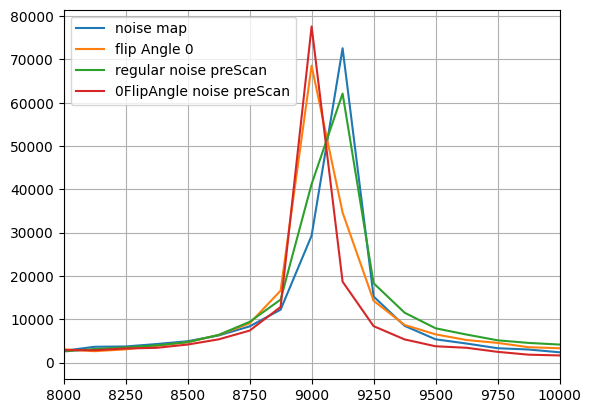

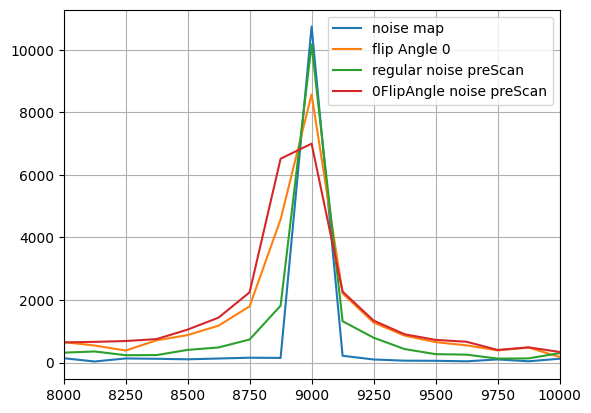

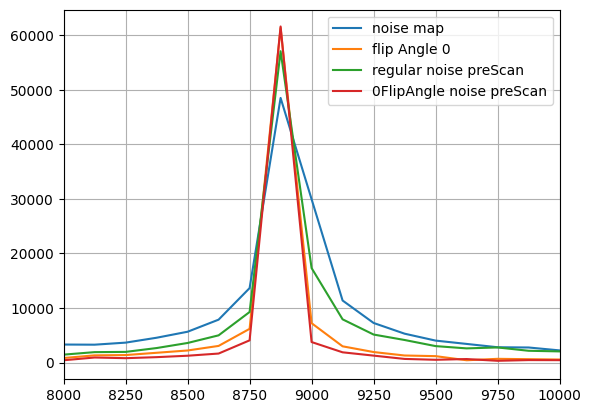

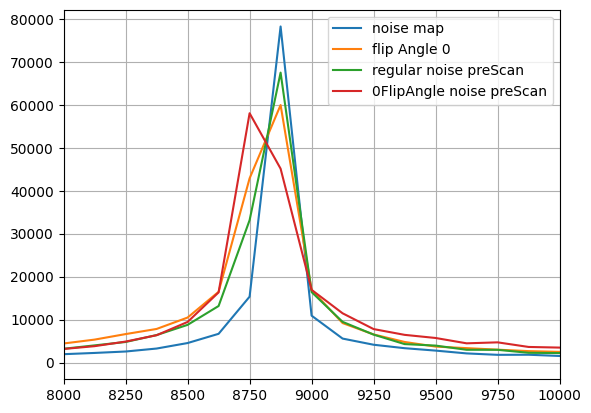

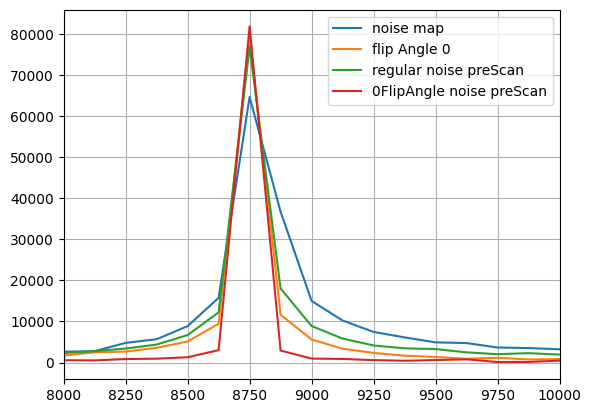

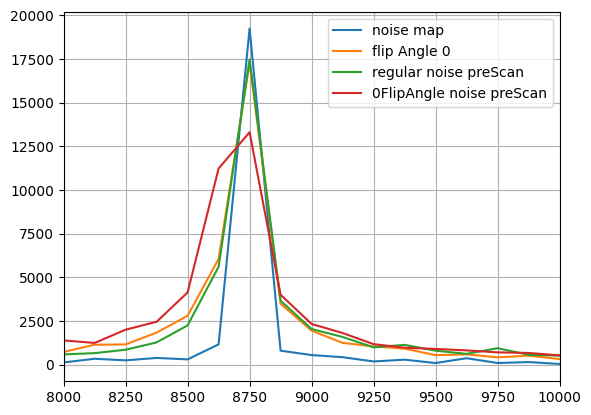

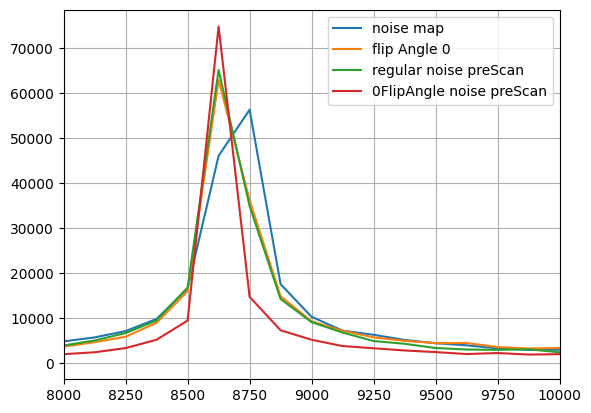

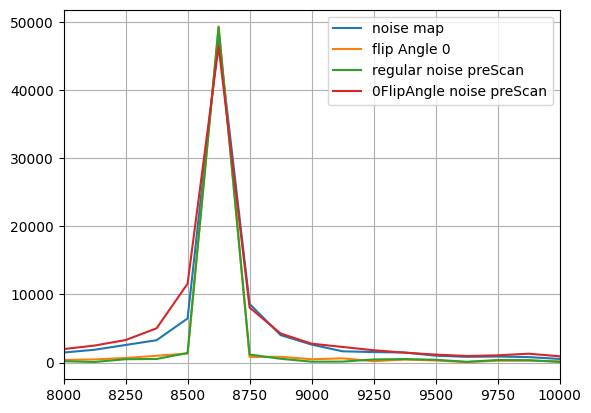

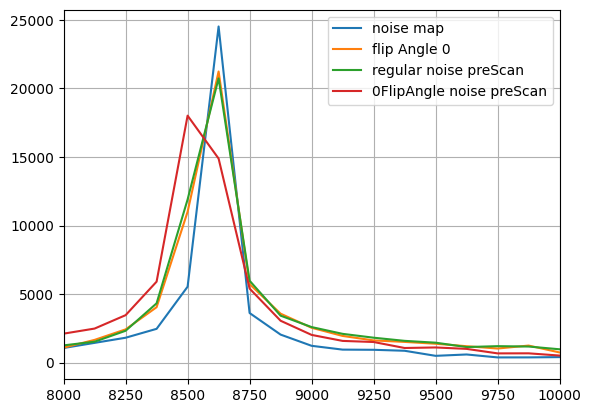

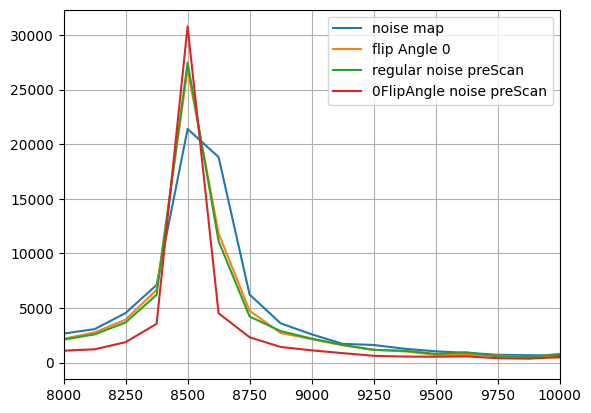

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:/JiaxingData/EMINoise/20250122/AMSquareSFA30_11.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [54]:
def plotAcqSamples(noiseImage,flip0,noisePre,noisePre0,date,mode,type,trial):
    
    i1 = np.random.randint(0,len(noiseImage))
    i2 = np.random.randint(0,16)
    
    #noiseOnly = noiseOnly[i1,i2]
    noise = noiseImage[i1,i2]
    #noiseImage = noiseImage[i1,i2] - baseline[i1,i2]
    flip0 = flip0[i1,i2]
    noisePre = noisePre[0,i2,0:512]
    noisePre0 = noisePre0[0,i2,0:512]

    #fft1 = np.fft.fft(noiseOnly)
    fft2 = np.fft.fft(noise)
    fft3 = np.fft.fft(flip0)
    fft4 = np.fft.fft(noisePre)
    fft5 = np.fft.fft(noisePre0)
    #phase1 = np.angle(fft1)
    #ps1 = 20*np.log10(np.abs(fft1)**2)


    #sampling_frequency1 = common.getRate('E:/JiaxingData/EMINoise/0827/NoiseSignal_32_256.h5')
    sampling_frequency2 = common.getRate('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'SFA30_'+trial+'.h5')
    sampling_frequency3 = common.getRate('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'SFA0_'+trial+'.h5')
    #freqs1 = np.fft.fftfreq(len(noiseOnly),1/sampling_frequency1)
    freqs2 = np.fft.fftfreq(len(noise),1/sampling_frequency2)
    freqs3 = np.fft.fftfreq(len(flip0),1/sampling_frequency3)
    freqs4 = np.fft.fftfreq(len(noisePre),1/sampling_frequency2)



    #plt.plot(freqs1[:len(freqs1)//2],np.abs(fft1)[:len(freqs1)//2])
    plt.plot(freqs2[:len(freqs2)//2],np.abs(fft2)[:len(freqs2)//2])
    plt.plot(freqs3[:len(freqs3)//2],np.abs(fft3)[:len(freqs3)//2])
    plt.plot(freqs2[:len(freqs4)//2],np.abs(fft4)[:len(freqs2)//2])
    plt.plot(freqs3[:len(freqs3)//2],np.abs(fft5)[:len(freqs3)//2])
    plt.xlim(8000, 10000)
    plt.grid()
    plt.legend(['noise map','flip Angle 0','regular noise preScan', '0FlipAngle noise preScan'])
    #plt.savefig('E:/JiaxingData/EMINoise/'+date+'/spectrumPlot/'+mode+type+trial+'_absFFT_'+str(i1)+'_'+str(i2)+'.png')
    #plt.plot(freqs[:len(freqs)//2],np.abs(fft)[:len(freqs)//2])
    plt.show()
    
date = '20250122'
for mode in ['AM']:
    for type in ['Square']:
        for trial in ['1','2','3','4','5','6','7','8','9','10','11','12','13',
                      '14','15','16','17','18','19','20','21','22','23','24','25']:
            #noiseOnly,b = common.readAllAcqs('E:/JiaxingData/EMINoise/1205/FA0Run1.h5')
            #noiseOnly = dp.ConvergeComplexR(dp.SplitComplexR(noiseOnly))
            noiseImage,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'SFA30_'+trial+'.h5')
            noiseImage = dp.ConvergeComplexR(dp.SplitComplexR(noiseImage))
            #baseline,b = common.readAllAcqs('E:/JiaxingData/EMINoise/'+date+'/FA77Baseline.h5')
            #baseline = dp.ConvergeComplexR(dp.SplitComplexR(baseline))
            flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'SFA0_'+trial+'.h5')
            flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))
            noisePre,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'SFA30_'+trial+'.h5',table_name="noise")
            noisePre = dp.ConvergeComplexR(dp.SplitComplexR(noisePre))
            noisePre0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'SFA0_'+trial+'.h5',table_name="noise")
            noisePre0 = dp.ConvergeComplexR(dp.SplitComplexR(noisePre0))
            
            plotAcqSamples(noiseImage,flip0,noisePre,noisePre0,date,mode,type,trial)

20
20


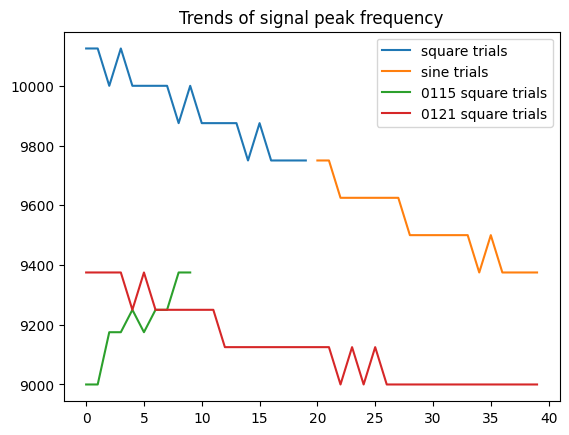

In [8]:
data1 = [10125,10125,10000,10125,10000,10000,10000,10000,
        9875,10000,9875,9875,9875,9875,9750,9875,
        9750,9750,9750,9750]
print(len(data1))
data2 = [9750,9750,9625,9625,9625,9625,9625,9625,
         9500,9500,9500,9500,9500,9500,9375,9500,
         9375,9375,9375,9375]
DATA = [9000,9000,9175,9175,9250,9175,9250,9250,9375,9375]
data3 = [9375,9375,9375,9375,9250,9375,9250,9250,9250,9250,
         9250,9250,9125,9125,9125,9125,9125,9125,9125,9125,
         9125,9125,9000,9125,9000,9125,9000,9000,9000,9000,
         9000,9000,9000,9000,9000,9000,9000,9000,9000,9000]
print(len(data2))
plt.plot(range(20),data1)
plt.plot(range(20,40),data2)
plt.plot(range(10),DATA)
plt.plot(range(40),data3)
plt.legend(['square trials','sine trials','0115 square trials','0121 square trials'])
plt.title('Trends of signal peak frequency')
plt.show()


In [50]:
#pre-scan denoising
def TFCalculation2(sig,channel=18):
    MRISignal = sig[0:16]
    if channel == 18:
        EMISignal = sig[16:18]
        tf = np.zeros((16,2),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal))
    else:
        EMISignal = sig[channel]
        tf = np.zeros((16,1),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal.reshape(1,len(EMISignal))))
    return tf

def denoising4(sig,tf,channel2=18):
    denoised = np.zeros((512,16,512),dtype=np.complex64)
    for i in range(512):
        if channel2 == 18:
            EMISignal = sig[i,16:18]
            pred = np.dot(tf,EMISignal)
            denoised[i] = sig[i,0:16] - pred
        else:
            EMISignal = sig[i,channel2]
            pred = np.dot(tf,EMISignal.reshape(1,512))
            denoised[i] = sig[i,0:16] - pred
    return denoised

def experiment2DTable(meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb):
    table = PrettyTable(["","Before suppression","After suppression with Channel 16 and 17",
                          "Suppression Rate3"])
    table.add_row(["mean",meanBefore,meanSupComb,SRMeanSupComb]) 
    table.add_row(["peak",peakBefore,peakSupComb,SRPeakSupComb]) 
    table.add_row(["standard deviation",stdBefore,stdSupComb,SRStdSupComb]) 
    print(table)

def experiment2DCalculation(before,supComb):
    meanBefore = mean(before)
    peakBefore = peak(before)
    stdBefore = std(before)
    meanSupComb = mean(supComb)
    peakSupComb = peak(supComb)
    stdSupComb = std(supComb)
    SRMeanSupComb = 1 - (np.abs(meanSupComb)/np.abs(meanBefore))
    SRPeakSupComb = 1 - (np.abs(peakSupComb)/np.abs(peakBefore))
    SRStdSupComb = 1 - (np.abs(stdSupComb)/np.abs(stdBefore))
    experiment2DTable(meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb)
    #return meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb


date = '20250121'
for mode in ['AM']:
    for type in ['Square']:
        #'1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25'
        for trial in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25']:
            fPath = 'C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'FA77_'+trial+'.h5'
            noiseImage,b = common.readAllAcqs(fPath)
            noiseImage = dp.ConvergeComplexR(dp.SplitComplexR(noiseImage))
            noisePre,b = common.readAllAcqs(fPath,table_name="noise")
            noisePre = dp.ConvergeComplexR(dp.SplitComplexR(noisePre))
            noisePreSize = noisePre.shape
            noisePre = noisePre.reshape(noisePreSize[1],noisePreSize[0]*noisePreSize[2])
            tf = TFCalculation2(noisePre, 18)

            denoised = denoising4(noiseImage,tf)

            denoised = np.mean(denoised,axis = 0)
            noiseImage = np.mean(noiseImage[:,0:16],axis = 0)
            
            experiment2DCalculation(noiseImage,denoised)
            #tt.storePrediction(fPath,'NoisyImg',dp.complexRearrangement(denoised))
            #tt.storePrediction18To16(fPath, 'NoisyImg') 



+--------------------+-----------------------------+------------------------------------------+--------------------+
|                    |      Before suppression     | After suppression with Channel 16 and 17 | Suppression Rate3  |
+--------------------+-----------------------------+------------------------------------------+--------------------+
|        mean        | (0.002269867+0.0044568824j) |       (0.0021764892+0.005235582j)        |     -0.1336267     |
|        peak        |    (9.201352+2.2087505j)    |           (5.86573-2.5136402j)           |     0.32560468     |
| standard deviation |      2.222020980292892      |            0.4077525329171996            | 0.8164947421588016 |
+--------------------+-----------------------------+------------------------------------------+--------------------+
+--------------------+-----------------------------+------------------------------------------+--------------------+
|                    |      Before suppression     | After suppr

In [49]:
#calculate overall transfer function by waveform
def TFCalculation2(sig,channel=18):
    MRISignal = sig[0:16]
    if channel == 18:
        EMISignal = sig[16:18]
        tf = np.zeros((16,2),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal))
    else:
        EMISignal = sig[channel]
        tf = np.zeros((16,1),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal.reshape(1,len(EMISignal))))
    return tf

def denoising4(sig,tf,channel2=18):
    denoised = np.zeros((512,16,512),dtype=np.complex64)
    for i in range(512):
        if channel2 == 18:
            EMISignal = sig[i,16:18]
            pred = np.dot(tf,EMISignal)
            denoised[i] = sig[i,0:16] - pred
        else:
            EMISignal = sig[i,channel2]
            pred = np.dot(tf,EMISignal.reshape(1,512))
            denoised[i] = sig[i,0:16] - pred
    return denoised

def experiment2DTable(meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb):
    table = PrettyTable(["","Before suppression","After suppression with Channel 16 and 17",
                          "Suppression Rate3"])
    table.add_row(["mean",meanBefore,meanSupComb,SRMeanSupComb]) 
    table.add_row(["peak",peakBefore,peakSupComb,SRPeakSupComb]) 
    table.add_row(["standard deviation",stdBefore,stdSupComb,SRStdSupComb]) 
    print(table)

def experiment2DCalculation(before,supComb):
    meanBefore = mean(before)
    peakBefore = peak(before)
    stdBefore = std(before)
    meanSupComb = mean(supComb)
    peakSupComb = peak(supComb)
    stdSupComb = std(supComb)
    SRMeanSupComb = 1 - (np.abs(meanSupComb)/np.abs(meanBefore))
    SRPeakSupComb = 1 - (np.abs(peakSupComb)/np.abs(peakBefore))
    SRStdSupComb = 1 - (np.abs(stdSupComb)/np.abs(stdBefore))
    experiment2DTable(meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb)
    #return meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb
long = []
date = '20250121'
for mode in ['AM']:
    for type in ['Square']:
        #'1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25'
        for trial in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25']:
            flip0,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'FA0_'+trial+'.h5')
            flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))
            for i in range(512):
                long.append(flip0[i])
long = np.array(long)
longSize = long.shape
long = long.transpose(1, 0, 2).reshape(longSize[1],longSize[0]*longSize[2])
print(long.shape)
tf = TFCalculation2(long, 18)



for mode in ['AM']:
    for type in ['Square']:
        for trial in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25']:
            fPath = 'C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'FA77_'+trial+'.h5'
            noiseImage,b = common.readAllAcqs(fPath)
            noiseImage = dp.ConvergeComplexR(dp.SplitComplexR(noiseImage))

            denoised = denoising4(noiseImage,tf)
            denoised = np.mean(denoised,axis = 0)
            noiseImage = np.mean(noiseImage[:,0:16],axis = 0)
            experiment2DCalculation(noiseImage,denoised)
            #tt.storePrediction(fPath,'NoisyImg',dp.complexRearrangement(denoised))
            #tt.storePrediction18To16(fPath, 'NoisyImg') 
 


(18, 6553600)
+--------------------+-----------------------------+------------------------------------------+--------------------+
|                    |      Before suppression     | After suppression with Channel 16 and 17 | Suppression Rate3  |
+--------------------+-----------------------------+------------------------------------------+--------------------+
|        mean        | (0.002269867+0.0044568824j) |       (0.0025003809+0.0046911873j)       |    -0.062844396    |
|        peak        |    (9.201352+2.2087505j)    |          (6.011793-2.5075269j)           |     0.31163895     |
| standard deviation |      2.222020980292892      |            0.4094927387742507            | 0.8157115786007232 |
+--------------------+-----------------------------+------------------------------------------+--------------------+
+--------------------+-----------------------------+------------------------------------------+--------------------+
|                    |      Before suppression    

In [48]:
#calculate 1d table of noise and baseline

def experiment2DTable(meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb):
    table = PrettyTable(["","Before suppression","After suppression with Channel 16 and 17",
                          "Suppression Rate3"])
    table.add_row(["mean",meanBefore,meanSupComb,SRMeanSupComb]) 
    table.add_row(["peak",peakBefore,peakSupComb,SRPeakSupComb]) 
    table.add_row(["standard deviation",stdBefore,stdSupComb,SRStdSupComb]) 
    print(table)

def experiment2DCalculation(before,supComb):
    meanBefore = mean(before)
    peakBefore = peak(before)
    stdBefore = std(before)
    meanSupComb = mean(supComb)
    peakSupComb = peak(supComb)
    stdSupComb = std(supComb)
    SRMeanSupComb = 1 - (np.abs(meanSupComb)/np.abs(meanBefore))
    SRPeakSupComb = 1 - (np.abs(peakSupComb)/np.abs(peakBefore))
    SRStdSupComb = 1 - (np.abs(stdSupComb)/np.abs(stdBefore))
    experiment2DTable(meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb)
    #return meanBefore,peakBefore,stdBefore,meanSupComb,peakSupComb,stdSupComb,SRMeanSupComb,SRPeakSupComb,SRStdSupComb

date = '20250121'
for mode in ['AM']:
    for type in ['Square']:
        for trial in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25']:
            fPath = 'C:/JiaxingData/EMINoise/'+date+'/'+mode+type+'FA77_'+trial+'.h5'
            noiseImage,b = common.readAllAcqs(fPath)
            noiseImage = dp.ConvergeComplexR(dp.SplitComplexR(noiseImage))
            baseline,b = common.readAllAcqs('C:/JiaxingData/EMINoise/'+date+'/AMSquareBFA77.h5')
            baseline = dp.ConvergeComplexR(dp.SplitComplexR(baseline))

            baseline = np.mean(baseline[:,0:16],axis = 0)
            noiseImage = np.mean(noiseImage[:,0:16],axis = 0)
            experiment2DCalculation(noiseImage,baseline)
            #tt.storePrediction(fPath,'NoisyImg',dp.complexRearrangement(denoised))
            #tt.storePrediction18To16(fPath, 'NoisyImg') 

C:\Users\11616\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\_methods.py:164: ComplexWarning: Casting complex values to real discards the imaginary part
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


+--------------------+-----------------------------+------------------------------------------+-------------------+
|                    |      Before suppression     | After suppression with Channel 16 and 17 | Suppression Rate3 |
+--------------------+-----------------------------+------------------------------------------+-------------------+
|        mean        | (0.002269867+0.0044568824j) |       (0.0016160784+0.0013473054j)       |     0.5793295     |
|        peak        |    (9.201352+2.2087505j)    |          (4.880104+2.2397764j)           |     0.4325592     |
| standard deviation |      2.222020980292892      |            0.384417927806714             | 0.826996265464585 |
+--------------------+-----------------------------+------------------------------------------+-------------------+
+--------------------+-----------------------------+------------------------------------------+--------------------+
|                    |      Before suppression     | After suppression 

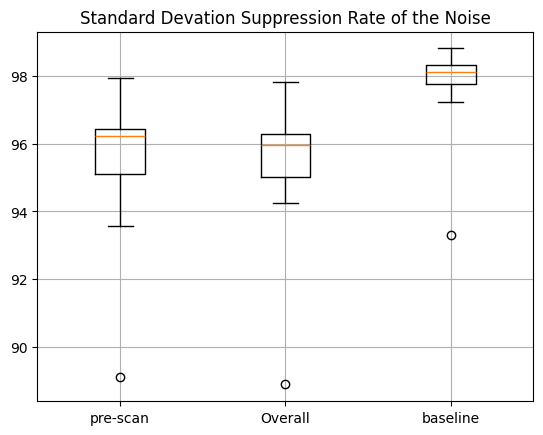

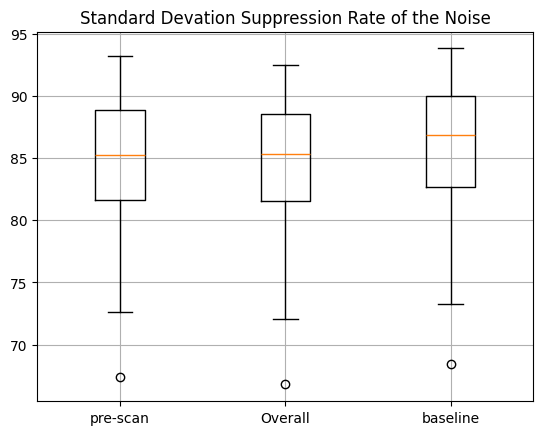

In [53]:

data1 = [[93.56,95.09,95.12,96.45,96.11,97.96,96.34,97.45,89.10,96.38],
         [95.13,94.26,94.97,95.85,96.25,97.84,96.30,97.29,88.88,96.09],
         [98.37,97.25,97.73,98.17,98.20,98.82,97.86,98.67,93.30,98.05]]

labels = ['pre-scan','Overall','baseline']
plt.boxplot(data1,tick_labels=labels)
#plt.boxplot(data2)
#plt.boxplot(data3)
plt.title('Standard Devation Suppression Rate of the Noise')
plt.grid()
plt.show()
data2 = [[81.65,83.17,89.74,86.45,89.83,88.18,84.14,89.54,85.25,86.74,
          89.07,79.90,84.62,88.88,77.65,85.10,93.18,85.03,80.45,67.41,
          86.81,79.09,87.03,91.35,72.59],
          [81.57,82.91,89.54,86.11,89.75,88.00,83.65,88.55,84.99,86.53,
           88.69,78.64,84.12,88.58,77.08,85.31,92.44,84.30,79.90,66.79,
           86.16,78.60,86.48,90.56,72.02],
           [82.70,83.98,91.58,88.60,92.34,90.02,85.70,90.41,86.88,88.17,
            92.50,81.12,86.73,89.44,78.46,86.78,93.80,85.61,81.23,68.42,
            87.55,80.10,87.64,91.64,73.24]]
labels = ['pre-scan','Overall','baseline']
plt.boxplot(data2,tick_labels=labels)
plt.title('Standard Devation Suppression Rate of the Noise')
plt.grid()
plt.show()